In [1]:
from torch.utils.data import DataLoader, Dataset
import torch
from zipfile import ZipFile
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import io
from PIL import Image
# from generic_dataloader_zip import *

In [4]:


def show_box2d(sample):
    image = sample['image']
    labels = sample['labels']

    for child in labels['children']:
        start_point = (child['x0'], child['y0'])
        end_point = (child['x1'], child['y1'])
        color = (255, 0, 0)
        thickness = 3
        image = cv2.rectangle(image, start_point, end_point, color, thickness)

    plt.imshow(image)
    plt.pause(0.001)


class ToTarget(object):
    """ Convert raw data to target format to train network.
    Network specific implementation might be needed. """

    def __call__(self, sample):

        # load raw data
        image, labels = sample['image'], sample['labels']

        """ process input """
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        _, h, w = image.shape

        """ process labels """
        targets = labels
        # rescale box2d, do something else...

        return {'image': torch.from_numpy(image), 'targets': targets}


class EcpDataset(Dataset):
    """ ECP Dataset Class - inherits from std PyTorch Dataset class
    inspired by
        https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
        https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
    """

    def __init__(self, path_zip_images, path_zip_labels, transform=None):

        # check given input
        assert os.path.isfile(path_zip_images), 'Does not exist / not a file: %s' % path_zip_images
        assert os.path.isfile(path_zip_labels), 'Does not exist / not a file: %s' % path_zip_labels
        assert path_zip_images[-4:] == '.zip', 'File name extension does not indicate a zip file: %s' % path_zip_images[-4:]
        assert path_zip_labels[-4:] == '.zip', 'File name extension does not indicate a zip file: %s' % path_zip_labels[-4:]
        self.path_zip_images = path_zip_images
        self.path_zip_labels = path_zip_labels

        # set transfrom
        self.transform = transform

        # read all png images from zip file (do not extract yet)
        self.image_names = []
        with ZipFile(self.path_zip_images, 'r') as zipFile:
            for name in zipFile.namelist():
                if name[-4:] == '.png':
                    self.image_names.append(name)
                else:
                    continue
        # sort image names alphabetically to assert same order as labels
        self.image_names.sort()
        print('%d images added to data loader.' % len(self.image_names))

        # read all json label files from zip file (do not extract yet)
        self.label_names = []
        with ZipFile(self.path_zip_labels, 'r') as zipFile:
            for name in zipFile.namelist():
                if name[-5:] == '.json':
                    self.label_names.append(name)
                else:
                    continue
        # sort label names alphabetically to assert same order as images
        self.label_names.sort()
        print('%d label files added to data loader.' % len(self.label_names))

        # assert same number of images and label files (one for each)
        assert len(self.image_names) == len(self.label_names)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):

        # convert to list if idx is tensor
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # extract and read image file
        with ZipFile(self.path_zip_images, 'r') as zipFile:
            image = zipFile.read(self.image_names[idx])
            image = Image.open(io.BytesIO(image))
            image = np.array(image)

        # extract and read label file
        with ZipFile(self.path_zip_labels, 'r') as zipFile:
            labels = zipFile.read(self.label_names[idx])
            labels = labels.decode('utf-8')
            # print(labels)
            labels = json.loads(labels)
            print(labels)

        # compose data sample as dict
        sample = {'image': image, 'labels': labels}

        # apply transform if given
        if self.transform:
            sample = self.transform(sample)

        return sample

{'tags': [], 'imageheight': 1024, 'imagewidth': 1920, 'children': [{'tags': [], 'x0': 429, 'children': [], 'y1': 687, 'y0': 482, 'x1': 525, 'Orient': 22.0, 'identity': 'pedestrian'}, {'tags': [], 'x0': 497, 'y1': 740, 'y0': 476, 'x1': 610, 'children': [{'tags': [], 'x0': 487, 'children': [], 'y1': 790, 'y0': 568, 'x1': 601, 'Orient': 11.0, 'identity': 'bicycle'}], 'identity': 'rider'}, {'tags': [], 'x0': 756, 'y1': 576, 'y0': 538, 'x1': 820, 'children': [], 'identity': 'bicycle-group'}, {'tags': [], 'x0': 862, 'y1': 563, 'y0': 532, 'x1': 892, 'children': [], 'identity': 'bicycle-group'}, {'tags': [], 'x0': 942, 'y1': 552, 'y0': 527, 'x1': 954, 'children': [], 'identity': 'pedestrian'}, {'tags': [], 'x0': 1087, 'y1': 582, 'y0': 523, 'x1': 1177, 'children': [], 'identity': 'bicycle-group'}, {'tags': [], 'x0': 906, 'y1': 552, 'y0': 527, 'x1': 914, 'children': [], 'identity': 'person-group-far-away'}, {'tags': [], 'x0': 974, 'y1': 550, 'y0': 527, 'x1': 984, 'children': [], 'identity': 'per

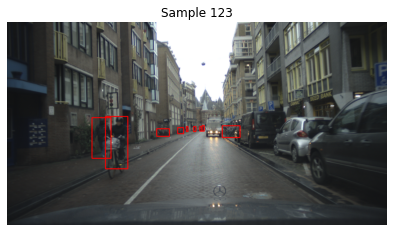

In [7]:
# plot sample image
id = 123
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
plt.tight_layout()
ax.set_title('Sample %03d' % id)
ax.axis('off')
show_box2d(ecpDataset[id])
plt.show()

23892 images added to data loader.
23892 label files added to data loader.
{'tags': [], 'imageheight': 1024, 'imagewidth': 1920, 'children': [{'tags': [], 'x0': 429, 'children': [], 'y1': 687, 'y0': 482, 'x1': 525, 'Orient': 22.0, 'identity': 'pedestrian'}, {'tags': [], 'x0': 497, 'y1': 740, 'y0': 476, 'x1': 610, 'children': [{'tags': [], 'x0': 487, 'children': [], 'y1': 790, 'y0': 568, 'x1': 601, 'Orient': 11.0, 'identity': 'bicycle'}], 'identity': 'rider'}, {'tags': [], 'x0': 756, 'y1': 576, 'y0': 538, 'x1': 820, 'children': [], 'identity': 'bicycle-group'}, {'tags': [], 'x0': 862, 'y1': 563, 'y0': 532, 'x1': 892, 'children': [], 'identity': 'bicycle-group'}, {'tags': [], 'x0': 942, 'y1': 552, 'y0': 527, 'x1': 954, 'children': [], 'identity': 'pedestrian'}, {'tags': [], 'x0': 1087, 'y1': 582, 'y0': 523, 'x1': 1177, 'children': [], 'identity': 'bicycle-group'}, {'tags': [], 'x0': 906, 'y1': 552, 'y0': 527, 'x1': 914, 'children': [], 'identity': 'person-group-far-away'}, {'tags': [], '

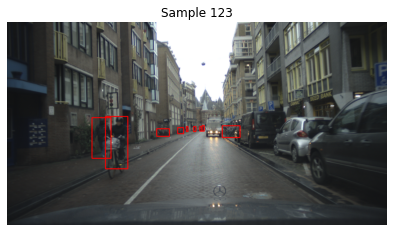

23892 images added to data loader.
23892 label files added to data loader.
{'tags': ['rainy'], 'imageheight': 1024, 'imagewidth': 1920, 'children': [{'tags': [], 'x0': 175, 'y1': 617, 'y0': 391, 'x1': 255, 'children': [], 'identity': 'person-group-far-away'}, {'tags': [], 'x0': 480, 'y1': 595, 'y0': 388, 'x1': 557, 'children': [], 'identity': 'person-group-far-away'}, {'tags': [], 'x0': 1144, 'y1': 563, 'y0': 544, 'x1': 1153, 'children': [], 'identity': 'rider+vehicle-group-far-away'}, {'tags': [], 'x0': 1153, 'y1': 573, 'y0': 547, 'x1': 1166, 'children': [{'tags': ['unsure_orientation'], 'x0': 1153, 'children': [], 'y1': 575, 'y0': 556, 'x1': 1166, 'Orient': 172.0, 'identity': 'bicycle'}], 'identity': 'rider'}, {'tags': [], 'x0': 1220, 'y1': 581, 'y0': 550, 'x1': 1230, 'children': [], 'identity': 'person-group-far-away'}], 'identity': 'frame'}
Loading batch 000...
{'tags': ['wiper'], 'imageheight': 1024, 'imagewidth': 1920, 'children': [{'tags': [], 'x0': 998, 'y1': 568, 'y0': 528, 'x

In [6]:
path_zip_images = '/home/minoda/datasets/ECP/ECP_day_img_train.zip'
path_zip_labels = '/home/minoda/datasets/ECP/ECP_day_labels_train.zip'

# get dataset object
ecpDataset = EcpDataset(path_zip_images, path_zip_labels)

id = 123
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
plt.tight_layout()
ax.set_title('Sample %03d' % id)
ax.axis('off')
show_box2d(ecpDataset[id])
plt.show()

# apply transformations
ecpDataset_transformed = EcpDataset(path_zip_images, path_zip_labels, transform=ToTarget())

# create pytorch data loader object which can be used for training
dataLoader = DataLoader(ecpDataset_transformed, batch_size=1, shuffle=False, num_workers=1)

# load some batches
for i_batch, sample_batched in enumerate(dataLoader):
    print('Loading batch %03d...' % i_batch)
    if i_batch > 5: break

In [19]:
sample_batched['targets']['children'][0]

{'tags': [],
 'x0': tensor([0]),
 'y1': tensor([583]),
 'y0': tensor([544]),
 'x1': tensor([17]),
 'children': [],
 'identity': ['bicycle-group']}

In [12]:
labels = sample_batched['targets']
x1, y1, x2, y2 = np.zeros(len(labels['children'])), np.zeros(len(labels['children'])), np.zeros(len(labels['children'])), np.zeros(len(labels['children']))

In [13]:
x1

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
labels

{'tags': [],
 'imageheight': tensor([1024]),
 'imagewidth': tensor([1920]),
 'children': [{'tags': [],
   'x0': tensor([0]),
   'y1': tensor([583]),
   'y0': tensor([544]),
   'x1': tensor([17]),
   'children': [],
   'identity': ['bicycle-group']},
  {'tags': [],
   'x0': tensor([106]),
   'y1': tensor([569]),
   'y0': tensor([523]),
   'x1': tensor([218]),
   'children': [],
   'identity': ['bicycle-group']},
  {'tags': [('occluded>10',)],
   'x0': tensor([549]),
   'children': [],
   'y1': tensor([534]),
   'y0': tensor([489]),
   'x1': tensor([565]),
   'Orient': tensor([11.], dtype=torch.float64),
   'identity': ['pedestrian']},
  {'tags': [('occluded>40',)],
   'x0': tensor([675]),
   'y1': tensor([532]),
   'y0': tensor([496]),
   'x1': tensor([689]),
   'children': [],
   'identity': ['pedestrian']},
  {'tags': [],
   'x0': tensor([977]),
   'y1': tensor([585]),
   'y0': tensor([549]),
   'x1': tensor([991]),
   'children': [],
   'identity': ['pedestrian']},
  {'tags': [],
   

In [ ]:
dd